In [34]:
import numpy as np
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D,Lambda
from keras.layers import MaxPooling2D,UpSampling2D,Concatenate,Conv2DTranspose
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
#from keras.models import load_model
from keras_retinanet.models import load_model
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.callbacks import LearningRateScheduler,Callback
from keras.optimizers import RMSprop
import cv2
from math import *
from keras.applications.vgg16 import VGG16 
import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import h5py
from keras.utils import to_categorical
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from sklearn import datasets,svm
from keras.preprocessing.image import ImageDataGenerator
from skimage import measure,img_as_float32
from imutils import contours
import imutils
import scipy.misc as sm
from PIL import Image
from timeit import default_timer as timer
from numba import *
import os
import keras.losses

import keras_retinanet.models.resnet
%matplotlib inline

#########################################################################################################################


In [50]:
odmodel = load_model('gt_new/Resnet_lr=0.001_dr=0.001_e=1e-8_ADAM_full6x.h5')
#odmodel = load_model('weights.80-958.91.h5',backbone_name={'huber_loss': huber_loss})
#odmodel = load_model('weights/Resnet_lr=0.001_dr=0.001_e=1e-8_ADAM.h5')
#odmodel = load_model('weights/Resnet_on_3696_160epoch.h5', custom_objects=custom_objects)

In [51]:
def predictor(full_image_pred,full_image):
    phaltu_time = timer()
    image = full_image_pred
    image[image<180] = 0

    blurred = cv2.GaussianBlur(image, (11, 11), 0)
    thresh = cv2.threshold(blurred,180, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=4)
    thresh = np.asarray(thresh, dtype = 'uint8')
    thresh[thresh>180] = 255
    cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if imutils.is_cv2() else cnts[1]
    if cnts:
        cnts = contours.sort_contours(cnts)[0]
        
    image = full_image
    cars = 0
    mini = 1000
    with open('Centers/2_FPN_res_x3_thres=192.txt', 'w') as file:
        for (i, c) in enumerate(cnts):
            (x, y, w, h) = cv2.boundingRect(c)

            if w*h < mini:
                mini = w*h
                print(mini)
            if w*h < 160:
                continue
            app = str(x) + " " + str(y) + "\n"
            file.write(app)
            cars = cars + 1
            rect = cv2.fitEllipse(c)
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            cv2.drawContours(image,[box],0,(255/255,255/255,0),2)
        #cv2.drawContours(image,[box],0,(255,0,0),2)
            

    plt.imshow(image,vmin = 0, vmax = 255)
    print("Total cars predicted = ", cars)
    return image

#########################################################################################################################
@jit(["void(float32,float32,int64,int64)"])
def place(prediction,full_image_p,y,x):
    for i in range(224):
        for j in range(224):
            full_image_p[y + i][x + j] = max(full_image_p[y + i][x + j],prediction[0][i][j])
            
#########################################################################################################################
def cropper(x_img,x0,y0):
    x0_end = x0 + 224
    y0_end = y0 + 224
    cropped_img = x_img[x0:x0_end,y0:y0_end]
    return cropped_img

In [52]:
im_p = "Images_for_FCRN/Test/2.JPG"
#ov = cv2.imread("new_pred/x.jpg")
#ov = cv2.cvtColor(ov, cv2.COLOR_BGR2RGB)

144
81
Total cars predicted =  500
Prediction Time =  16.43614407890709
The final time:  18.69069404801121


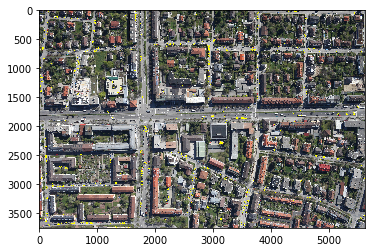

In [55]:
start = timer()
#########################################################################################################################
old_im = Image.open(im_p)
old_size = old_im.size
p = old_size[0]
q = old_size[1]
if p>224:
    new_x = (ceil(p/208)-1)*208 + 224
else:
    new_x = 224
if q>224:
    new_y = (ceil(q/208)-1)*208 + 224
else:
    new_y = 224


new_size = (new_x,new_y)
new_im = Image.new("RGB", new_size)   ## luckily, this is already black!
new_im.paste(old_im, ((int)((new_size[0]-old_size[0])/2), (int)((new_size[1]-old_size[1])/2)))
full_image = np.asarray(new_im,dtype = np.float32)

#########################################################################################################################
full_image_p = np.zeros((new_y,new_x),dtype = np.float32)

#########################################################################################################################
p_time = 0
for x in range(floor(new_x/208)):
    for y in range(floor(new_y/208)):
        img_part = cropper(full_image,y*208,x*208) # overlap = 16 therefore (224 - 16 = 208)
        img_part = np.asarray(img_part)
        img_part = img_part.reshape((1,224,224,3))
        img_part = 255 - img_part
        t1 = timer()
        prediction = odmodel.predict(img_part)
        p_time = p_time + timer() - t1
        prediction = np.asarray(prediction,dtype = np.float32)
        prediction = prediction.reshape((1,224,224))
        place(prediction,full_image_p,y*208,x*208)
#########################################################################################################################        
temp = full_image_p
bounded_image = predictor(temp,full_image/255)
#bounded_image = predictor(temp,ov)
print("Prediction Time = ",p_time)
print("The final time: ",timer()-start)

In [54]:
sm.imsave('new_pred/2_fpn_resx6_thres=180.jpg',bounded_image)

/home/sumeet/.virtualenvs/dl4cv/lib/python3.5/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  """Entry point for launching an IPython kernel.
